In [1]:
import torch
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from typing import List, Dict
from google.colab import drive

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
)
from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
%matplotlib inline

In [ ]:
from huggingface_hub import login
login("API_KEY")

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

GPU disponible: True
GPU: NVIDIA A100-SXM4-80GB
Memoria total: 79.25 GB


In [7]:
from datasets import Dataset
import json
import numpy as np

DATA_PATH = "/content/drive/MyDrive/datasetV2.jsonl"

raw_dataset = Dataset.from_json(DATA_PATH)
print(json.dumps(raw_dataset[0], indent=2, ensure_ascii=False))


def analyze_dataset(dataset):
    stats = {
        "total_examples": len(dataset),
        "prompt_lengths": [],
        "response_lengths": [],
    }

    for example in dataset:
        prompt = example["prompt"]
        response = example["response"]

        stats["prompt_lengths"].append(len(prompt.split()))
        stats["response_lengths"].append(len(response.split()))

    return stats


stats = analyze_dataset(raw_dataset)

print(f"Total ejemplos: {stats['total_examples']}")
print(f"Longitud promedio prompt de palabras: {np.mean(stats['prompt_lengths']):.2f}")
print(f"Longitud promedio response de palabras: {np.mean(stats['response_lengths']):.2f}")


{
  "prompt": "¿Es posible hacer compras al por mayor como revendedor?",
  "response": "¡Sí señor, parce! Tenemos programa especial pa' revendedores con precios exclusivos. ¿Le cuento cómo unirse?"
}
Total ejemplos: 500
Longitud promedio prompt de palabras: 5.48
Longitud promedio response de palabras: 23.53


/tmp/ipython-input-3068489553.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([prompt_lengths, response_lengths], labels=['Prompt', 'Response'])


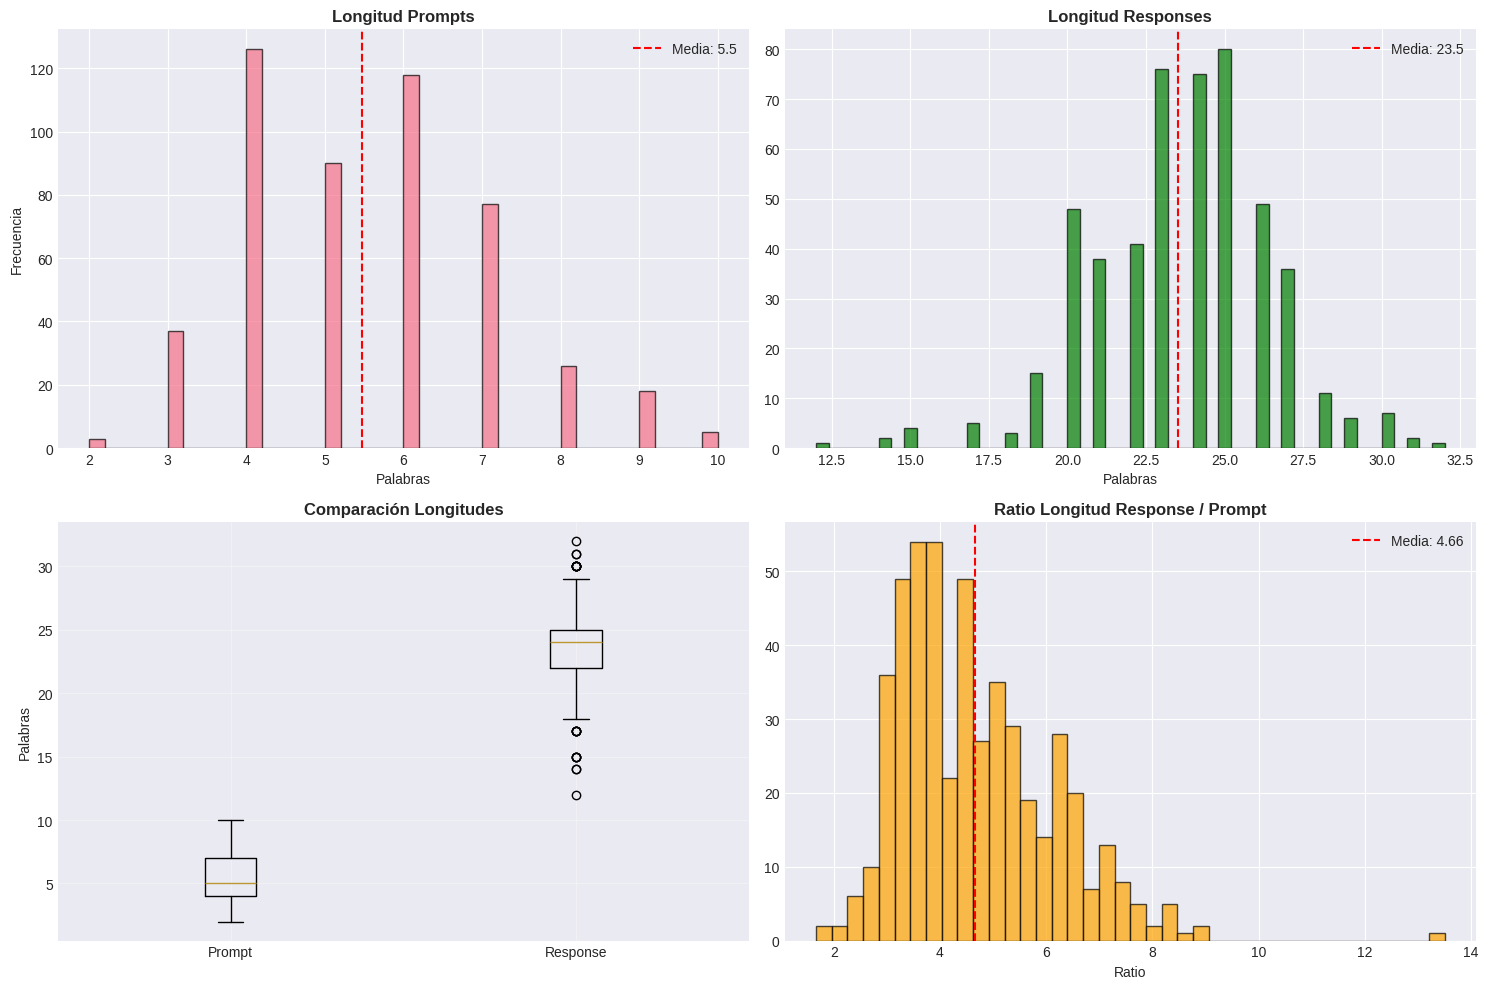

Prompts - Media: 5.48, Mediana: 5
Responses - Media: 23.53, Mediana: 24
Ejemplos válidos: 500


In [8]:
import numpy as np
import matplotlib.pyplot as plt

prompts = [ex["prompt"] for ex in raw_dataset if ex["prompt"] is not None]
responses = [ex["response"] for ex in raw_dataset if ex["response"] is not None]

prompt_lengths = [len(text.split()) for text in prompts]
response_lengths = [len(text.split()) for text in responses]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma longitud prompts
axes[0, 0].hist(prompt_lengths, bins=40, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Longitud Prompts', fontweight='bold')
axes[0, 0].set_xlabel('Palabras')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].axvline(np.mean(prompt_lengths), color='red', linestyle='--',
                   label=f'Media: {np.mean(prompt_lengths):.1f}')
axes[0, 0].legend()

# Histograma longitud responses
axes[0, 1].hist(response_lengths, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Longitud Responses', fontweight='bold')
axes[0, 1].set_xlabel('Palabras')
axes[0, 1].axvline(np.mean(response_lengths), color='red', linestyle='--',
                   label=f'Media: {np.mean(response_lengths):.1f}')
axes[0, 1].legend()

# Boxplot comparativo
axes[1, 0].boxplot([prompt_lengths, response_lengths], labels=['Prompt', 'Response'])
axes[1, 0].set_title('Comparación Longitudes', fontweight='bold')
axes[1, 0].set_ylabel('Palabras')
axes[1, 0].grid(True, alpha=0.3)

# Distribución ratio response/prompt
ratios = [r/p if p > 0 else 0 for r, p in zip(response_lengths, prompt_lengths)]
axes[1, 1].hist(ratios, bins=40, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Ratio Longitud Response / Prompt', fontweight='bold')
axes[1, 1].set_xlabel('Ratio')
axes[1, 1].axvline(np.mean(ratios), color='red', linestyle='--',
                   label=f'Media: {np.mean(ratios):.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"Prompts - Media: {np.mean(prompt_lengths):.2f}, Mediana: {np.median(prompt_lengths):.0f}")
print(f"Responses - Media: {np.mean(response_lengths):.2f}, Mediana: {np.median(response_lengths):.0f}")
print(f"Ejemplos válidos: {len(prompt_lengths)}")


  'parce': 288 veces
  'listo': 9 veces
  'chévere': 4 veces
  'qué más': 1 veces
  'todo bien': 1 veces

Top de palabras más frecuentes:
  parce: 288
  parcero: 130
  tenemos: 123
  puede: 107
  tiene: 83
  está: 77
  producto: 76


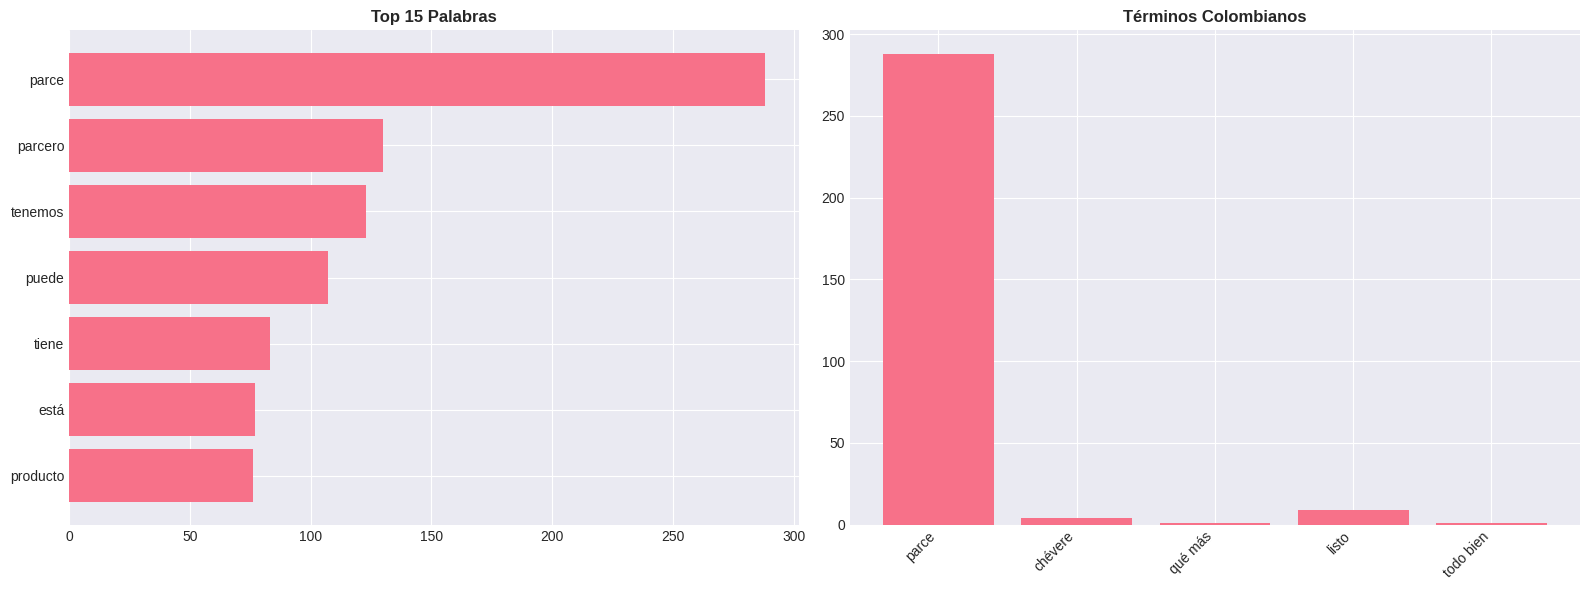

In [9]:
import re
from collections import Counter
import matplotlib.pyplot as plt

responses = [ex["response"] for ex in raw_dataset if ex["response"] is not None]
def extract_colombian_terms(texts):
    patterns = [
        r'\bsumercé\b', r'\bparce\b', r'\bchévere\b', r'\bberraco\b',
        r'\bpues\b', r'\bqué más\b', r'\bvea\b', r'\bmijo\b', r'\bmija\b',
        r'\blisto\b', r'\btodo bien\b', r'\ba la orden\b'
    ]
    
    all_text = ' '.join(texts).lower()
    colombian_counts = {}
    
    for pattern in patterns:
        matches = re.findall(pattern, all_text)
        if matches:
            term = pattern.replace(r'\b', '')
            colombian_counts[term] = len(matches)
    
    return colombian_counts


all_text = ' '.join(responses).lower()
words = re.findall(r'\b\w+\b', all_text)
word_freq = [(word, count) 
             for word, count in Counter(words).most_common(30) 
             if len(word) >= 4]

colombian_terms = extract_colombian_terms(responses)
for term, count in sorted(colombian_terms.items(), key=lambda x: x[1], reverse=True):
    print(f"  '{term}': {count} veces")

print("\nTop de palabras más frecuentes:")
for word, count in word_freq[:20]:
    print(f"  {word}: {count}")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
words_list, counts_list = zip(*word_freq[:15])
axes[0].barh(range(len(words_list)), counts_list)
axes[0].set_yticks(range(len(words_list)))
axes[0].set_yticklabels(words_list)
axes[0].set_title('Top 15 Palabras', fontweight='bold')
axes[0].invert_yaxis()

if colombian_terms:
    col_terms = list(colombian_terms.keys())
    col_counts = list(colombian_terms.values())
    
    axes[1].bar(range(len(col_terms)), col_counts)
    axes[1].set_xticks(range(len(col_terms)))
    axes[1].set_xticklabels(col_terms, rotation=45, ha='right')
    axes[1].set_title('Términos Colombianos', fontweight='bold')


plt.tight_layout()
plt.show()

In [10]:
from typing import Dict

def format_example_for_training(example: Dict) -> str:
    return (
        "<|start_header_id|>user<|end_header_id|>\n\n"
        f"{example['prompt']}<|eot_id|>"
        "<|start_header_id|>assistant<|end_header_id|>\n\n"
        f"{example['response']}<|eot_id|>"
    )


def process_dataset(example):
    return {"text": format_example_for_training(example)}


formatted_dataset = raw_dataset.map(
    process_dataset,
    remove_columns=raw_dataset.column_names
)

print(f"Formateado: {len(formatted_dataset)} ejemplos")
print("\nEjemplo:")
print(formatted_dataset[0]['text'][:400] + "...")


Formateado: 500 ejemplos

Ejemplo:
<|start_header_id|>user<|end_header_id|>

¿Es posible hacer compras al por mayor como revendedor?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

¡Sí señor, parce! Tenemos programa especial pa' revendedores con precios exclusivos. ¿Le cuento cómo unirse?<|eot_id|>...


In [11]:
train_test = formatted_dataset.train_test_split(test_size=0.2, seed=SEED)
test_val = train_test['test'].train_test_split(test_size=0.5, seed=SEED)

dataset_dict = DatasetDict({
    'train': train_test['train'],
    'validation': test_val['train'],
    'test': test_val['test']
})

print(f"Train: {len(dataset_dict['train'])}")
print(f"Validation: {len(dataset_dict['validation'])}")
print(f"Test: {len(dataset_dict['test'])}")

Train: 400
Validation: 50
Test: 50


In [12]:
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [28]:
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)


model = get_peft_model(model, lora_config)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Entrenables: {trainable:,}")
print(f"Total: {total:,}")
print(f"Porcentaje: {100 * trainable / total:.2f}%")

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Entrenables: 20,971,520
Total: 4,561,571,840
Porcentaje: 0.46%


In [29]:
OUTPUT_DIR = "/content/drive/MyDrive/llama_colombiano_checkpoints"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    learning_rate=8e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    bf16=True,
    tf32=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=SEED,
)

print(f"Épocas: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Batch efectivo: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Épocas: 3
Batch size: 4
Gradient accumulation: 4
Learning rate: 8e-05
Batch efectivo: 16


In [30]:
def formatting_func(example):
    return example["text"]

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    processing_class=tokenizer,
    formatting_func=formatting_func,
)

trainer.create_model_card = lambda *args, **kwargs: None


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.077105,1.521980
2,1.154792,1.220953
3,1.079955,1.183720


TrainOutput(global_step=75, training_loss=1.5737953249613443, metrics={'train_runtime': 223.7257, 'train_samples_per_second': 5.364, 'train_steps_per_second': 0.335, 'total_flos': 3627241135865856.0, 'train_loss': 1.5737953249613443})

In [32]:
model.print_trainable_parameters()

trainable params: 20,971,520 || all params: 8,051,232,768 || trainable%: 0.2605


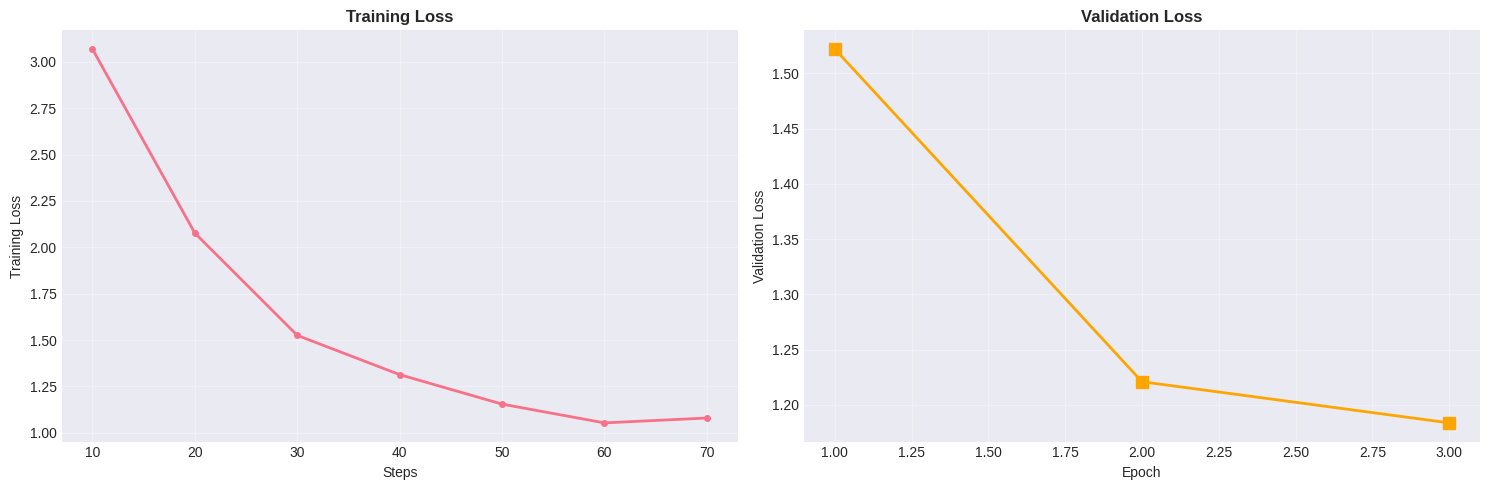

Train loss: 1.0800
Val loss: 1.1837
Mejor val loss: 1.1837


In [33]:
log_history = trainer.state.log_history

train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if train_logs:
    steps = [log['step'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    axes[0].plot(steps, losses, marker='o', linewidth=2, markersize=4)
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title('Training Loss', fontweight='bold')
    axes[0].grid(True, alpha=0.3)

if eval_logs:
    epochs = [log['epoch'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]
    axes[1].plot(epochs, eval_losses, marker='s', linewidth=2, markersize=8, color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_title('Validation Loss', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if eval_logs:
    print(f"Train loss: {train_logs[-1]['loss']:.4f}")
    print(f"Val loss: {eval_logs[-1]['eval_loss']:.4f}")
    print(f"Mejor val loss: {min(log['eval_loss'] for log in eval_logs):.4f}")

In [34]:
def generate_response(user_message: str, max_new_tokens: int = 150) -> str:
    prompt = f"""<|start_header_id|>user<|end_header_id|>

{user_message}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response.strip()

In [35]:
test_prompts = [
    "Hola",
    "Me interesa pero está muy caro",
    "¿Qué tal la calidad?",
    "No estoy seguro, déjame pensarlo",
    "¿Puedo pagar en cuotas?",
]


for i, prompt in enumerate(test_prompts, 1):
    print(f"\n[{i}] User: {prompt}")
    response = generate_response(prompt)
    print(f"Assistant: {response}")
    print("-"*80)


[1] User: Hola
Assistant: ¡Hola, parcero! ¿En qué podemos ayudarle hoy? Necesita información, tiene un problema o busca algo en particular?
--------------------------------------------------------------------------------

[2] User: Me interesa pero está muy caro
Assistant: ¡Entiendo su preocupación, parce! El precio es un poco alto, pero es por la calidad y el servicio que le brindamos. ¿Le explico qué incluye el producto pa' ver si vale la pena?
--------------------------------------------------------------------------------

[3] User: ¿Qué tal la calidad?
Assistant: ¡Excelente, parcero! Nuestras cosas son muy bien hechas y duraderas. Le garantizamos su satisfacción.
--------------------------------------------------------------------------------

[4] User: No estoy seguro, déjame pensarlo
Assistant: ¡Claro, parce! Tome el tiempo que necesite. Le envío la información y cuando esté listo le llamamos pa' confirmar.
-----------------------------------------------------------------------

In [53]:
FINAL_MODEL_PATH = "/content/drive/MyDrive/llama_colombiano_LoRA"

trainer.model.save_pretrained(FINAL_MODEL_PATH)
tokenizer.save_pretrained(FINAL_MODEL_PATH)

('/content/drive/MyDrive/llama_colombiano_LoRA/tokenizer_config.json',
 '/content/drive/MyDrive/llama_colombiano_LoRA/chat_template.jinja',
 '/content/drive/MyDrive/llama_colombiano_LoRA/tokenizer.json')